# Train

In [1]:
import torch
import torchvision
from pycocotools.coco import COCO

from torch.utils.data import Dataset,DataLoader
import os
from PIL import Image
# from torchvision.transforms import Compose
from torchvision.datasets import CocoDetection


In [2]:
ROOT_train = "/home/jiazhaohe/datasets/COCO_2017/train2017"
ROOT_val   = "/home/jiazhaohe/datasets/COCO_2017/val2017"
ann_train = "/home/jiazhaohe/datasets/COCO_2017/annotations/instances_train2017.json"
ann_val   = "/home/jiazhaohe/datasets/COCO_2017/annotations/instances_val2017.json"

In [3]:
import random  
from torchvision.transforms import functional as F
    
def collate_fn(batch):
    return tuple(zip(*batch))



class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
#         for i in range(len(target)):
#             target[i]["boxes"] = torch.as_tensor(target[i]["boxes"],dtype=torch.float32)
#             target[i]["labels"] = torch.as_tensor(target[i]["labels"],dtype=torch.int64)
        target["boxes"] = torch.as_tensor(target["boxes"],dtype=torch.float32)
        target["labels"] = torch.as_tensor(target["labels"],dtype=torch.int64)
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        """
            target是个list，里面是一个个dict
        """
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
#             bbox = [ t["boxes"] for t in target]
#             # 注意，这里bbox是python原生数组，不能用bbox[:,0]的方式
#             bbox[:][0] = width - bbox[:][0]
#             bbox[:][2] = width - bbox[:][2]
            bbox = target["boxes"]
            if len(bbox)>0:
                bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
                target["boxes"] = bbox
#             for i in range(len(target)):
#                 bbox = target[i]["boxes"]
#                 bbox[0] = width - bbox[0]
#                 bbox[2] = width - bbox[2]
#                 target[i]["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
    
    
    
class COCODataset(Dataset):
    
    def __init__(self,root,annotation,transforms):
        self.root = root
        self.transforms = transforms
        
        self.coco = COCO(annotation)
        ids = self.coco.getImgIds()
        imgs = []
        for img_id in ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            if len(ann_ids)>0:
                imgs.append(img_id)
        self.imgs = imgs
        self.cats = self.coco.getCatIds()
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self,index):
        name = self.coco.loadImgs(self.imgs[index])[0]["file_name"]
        img = pil_loader(os.path.join(self.root,name))
        annIds = self.coco.getAnnIds(imgIds=[self.imgs[index]])
        anns = self.coco.loadAnns(annIds)
        
        # 这种是返回的target是一个字典，有两个属性，boxes：(N,4)，和labels:(N,)
        boxes = []
        labels = []
        for ann in anns:
            box = [0,0,0,0]
            box[0] = ann["bbox"][0]
            box[1] = ann["bbox"][1]
            box[2] = ann["bbox"][0] + ann["bbox"][2]
            box[3] = ann["bbox"][1] + ann["bbox"][3]
            boxes.append(box)
            labels.append(self.cats.index(ann["category_id"]))
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

    
#         # 这种返回的target是一个由dict组成的list，每个dict有两个属性，boxes:(4,) 和 labels: Int64
#         # 注意，loadAnns的结果本身是个list，所以这种方式其实是它的一个子集
#         target = []
#         for ann in anns:
#             item = {}
#             box = [0,0,0,0]
#             box[0] = ann["bbox"][0]
#             box[1] = ann["bbox"][1]
#             box[2] = ann["bbox"][0] + ann["bbox"][2]
#             box[3] = ann["bbox"][1] + ann["bbox"][3]
#             item["boxes"] = box
#             item["labels"] = self.cats.index(ann["category_id"])
#             target.append(item)
        if self.transforms is not None:
            img,target = self.transforms(img,target)
#         print("COCO:",index,'\tboxes.len:',len(target["boxes"]),"imgID:",self.imgs[index])
        return img,target

In [4]:

coco_dataset_train = COCODataset(root=ROOT_train,
                                 annotation=ann_train,
                                 transforms=Compose([
                                       ToTensor(),
                                       RandomHorizontalFlip(0.5)
                                 ]))
coco_dataset_val = COCODataset(root=ROOT_val,
                               annotation=ann_val,
                               transforms=ToTensor())
    


loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [5]:
# print(len(coco_dataset_train))

In [6]:

# idxs = []
# for i in range(len(coco_dataset_train)):
#     img,target = coco_dataset_train.__getitem__(i)
#     if i%100 == 0:
#         print("iter:",i,)
#     if len(target["boxes"])==0:
#         print("iter:",i," without boxes !!!")
#         idxs.append(i)

In [7]:
# coco_dataset_train.__len__()
# img,target = coco_dataset_train.__getitem__(215)

# print(img.shape)
# print(target["boxes"].shape)
# print(target["labels"].shape)
# print("target.boxes.len:",len(target["boxes"]))
# # for box,label in zip(target["boxes"],target["labels"]):
# #     print(box,label)
# print(target)

# # show some images inside dataset

# import matplotlib.pyplot as plt
# import matplotlib
# %matplotlib inline
# # %matplotlib widget
# plt.rcParams["figure.figsize"] = (16,20)

# # plt.imshow(img.permute(1,2,0))
# fig, ax = plt.subplots()
# ax.imshow(img.permute(1,2,0))
# for item in target["boxes"]:
#     box_x = item[0].item()
#     box_y = item[1].item()
#     box_width = item[2].item() - item[0].item()
#     box_height = item[3].item() - item[1].item()
#     box_patch = matplotlib.patches.Rectangle((box_x,box_y),box_width,box_height,
#                                          linewidth=1,edgecolor='r',facecolor='none')
#     ax.add_patch(box_patch)
# plt.show()

In [8]:
train_sampler = torch.utils.data.SequentialSampler(coco_dataset_train)
val_sampler   = torch.utils.data.SequentialSampler(coco_dataset_val)
train_batch_sampler = torch.utils.data.BatchSampler(train_sampler,4,drop_last=True)

In [9]:
# trainLoader = DataLoader(coco_dataset_train,batch_sampler=train_batch_sampler,
#                          num_workers=8,collate_fn=collate_fn)
valLoader   = DataLoader(coco_dataset_val  ,batch_size=2,shuffle=False,
                         num_workers=1,collate_fn=collate_fn)


In [10]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [11]:
net = torchvision.models.resnet18(pretrained=True)
backbone = torch.nn.Sequential(net.conv1,net.bn1,net.relu,net.maxpool,
                               net.layer1,net.layer2,net.layer3,net.layer4)


In [12]:
backbone.out_channels = 512

In [13]:
anchor_generator = AnchorGenerator(sizes=((32,64,128,256,512)),
                                   aspect_ratios=((0.5,1.0,2.0)))


In [14]:
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

In [15]:
model = FasterRCNN(backbone,
                   num_classes=80,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [16]:
model = model.cuda()

In [17]:
criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(),lr=0.05,momentum=0.9,weight_decay=5e-4)

In [19]:


for i,(inputs,targets) in enumerate(valLoader):
    inputs = list(img.cuda() for img in inputs)
    targets = [{k: v.cuda() for k, v in t.items()} for t in targets]
    
    loss_dict = model(inputs,targets)
    print(loss_dict)
    losses = sum(loss for loss in loss_dict.values())
    if(i%20 == 0):
        break
        print("iter:",i,"\tloss:",losses.item(),"\t time:",time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    

2476
objectness: [tensor([[[[ 0.0154,  0.2435,  0.2613,  ...,  0.0084,  0.0190, -0.1525],
          [ 0.0197, -0.0344, -0.1632,  ..., -0.1237, -0.1117, -0.2559],
          [-0.0927, -0.3101, -0.4049,  ..., -0.2512, -0.1726, -0.1718],
          ...,
          [-0.1875, -0.2352, -0.2729,  ..., -0.2379, -0.1914, -0.2485],
          [-0.2046, -0.1179, -0.2230,  ..., -0.3146, -0.3569, -0.2631],
          [-0.0848, -0.0954, -0.1005,  ..., -0.2050, -0.1956, -0.2076]],

         [[ 0.2494,  0.1852,  0.1063,  ...,  0.0205, -0.0353, -0.1315],
          [ 0.2107,  0.1532,  0.1455,  ...,  0.1894,  0.1883,  0.0358],
          [ 0.1782,  0.0795,  0.0705,  ...,  0.4073,  0.2721,  0.0803],
          ...,
          [ 0.0060,  0.0584,  0.0838,  ...,  0.0568,  0.0036,  0.0378],
          [-0.0118,  0.0499,  0.0971,  ...,  0.0658,  0.0395,  0.0529],
          [ 0.0462,  0.1125,  0.1033,  ...,  0.1258,  0.1680,  0.1969]],

         [[-0.1226, -0.3017, -0.4950,  ..., -0.3208, -0.2300, -0.1595],
          [-

okay


In [1]:
import torch
import numpy

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,20)

data = torch.load("./models/rcnn_4.pth")

In [2]:
print(data.keys())

dict_keys(['epoch', 'state_dict', 'train_loss_classifier', 'train_loss_box_reg', 'train_loss_objectness', 'train_loss_rpn_box_reg', 'train_loss_sum', 'train_epoch_loss_classifier', 'train_epoch_loss_box_reg', 'train_epoch_loss_objectness', 'train_epoch_loss_rpn_box_reg', 'train_epoch_loss_sum', 'AP_50_95', 'AP_50', 'AP_75', 'AP_small', 'AP_medium', 'AP_large', 'AR_1', 'AR_10', 'AR_100', 'AR_small', 'AR_medium', 'AR_large'])


In [3]:
print(data["AP_50_95"])

[0.010184274234377901, 0.01533439748455527, 0.013550981368628737, 0.017566064489622724]


In [8]:
train_loss_classifier = data["train_loss_classifier"]
train_loss_box_reg = data["train_loss_box_reg"]
train_loss_objectness = data["train_loss_objectness"]
train_loss_rpn_box_reg = data["train_loss_rpn_box_reg"]
train_loss_sum = data["train_loss_sum"]


train_epoch_loss_classifier = data["train_epoch_loss_classifier"]
train_epoch_loss_box_reg = data["train_epoch_loss_box_reg"]
train_epoch_loss_objectness = data["train_epoch_loss_objectness"]
train_epoch_loss_rpn_box_reg = data["train_epoch_loss_rpn_box_reg"]
train_epoch_loss_sum = data["train_epoch_loss_sum"]


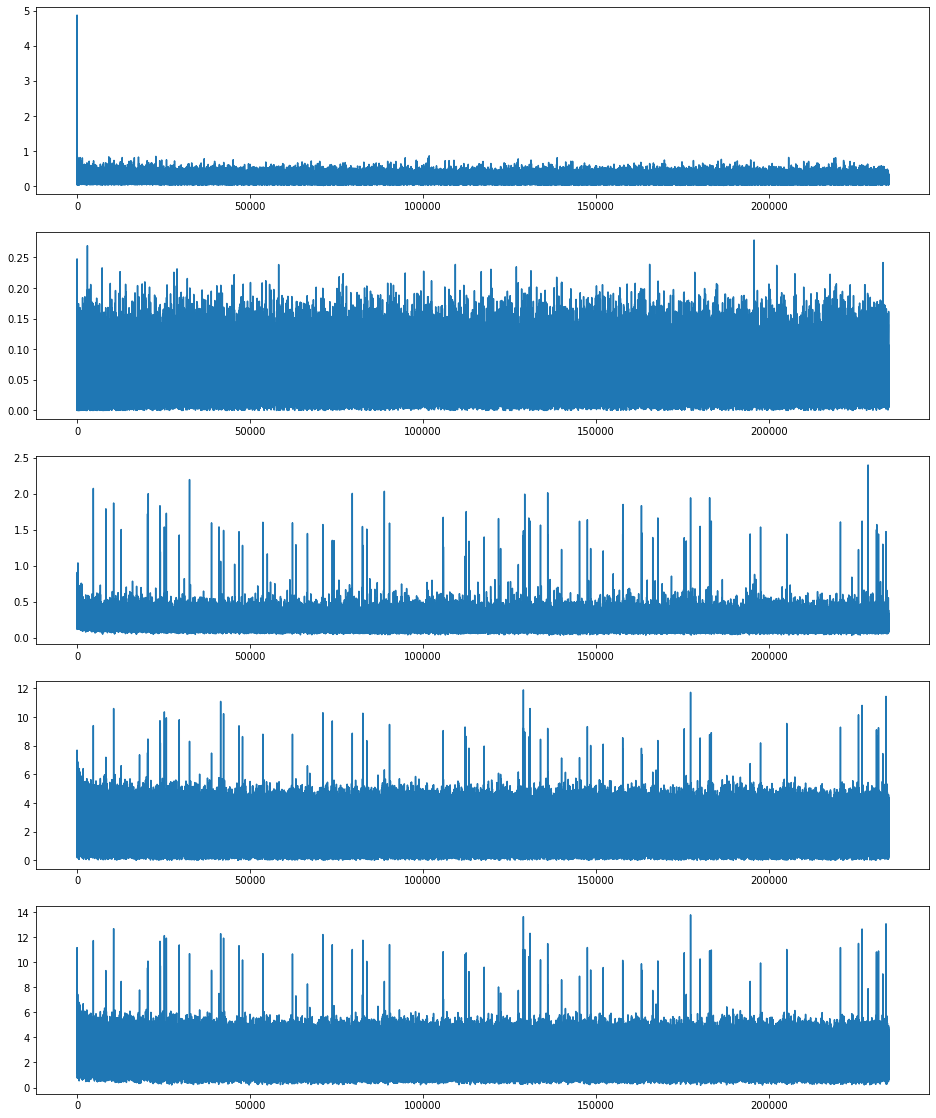

In [7]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1)

ax1.plot(train_loss_classifier)

ax2.plot(train_loss_box_reg)

ax3.plot(train_loss_objectness)

ax4.plot(train_loss_rpn_box_reg)

ax5.plot(train_loss_sum)



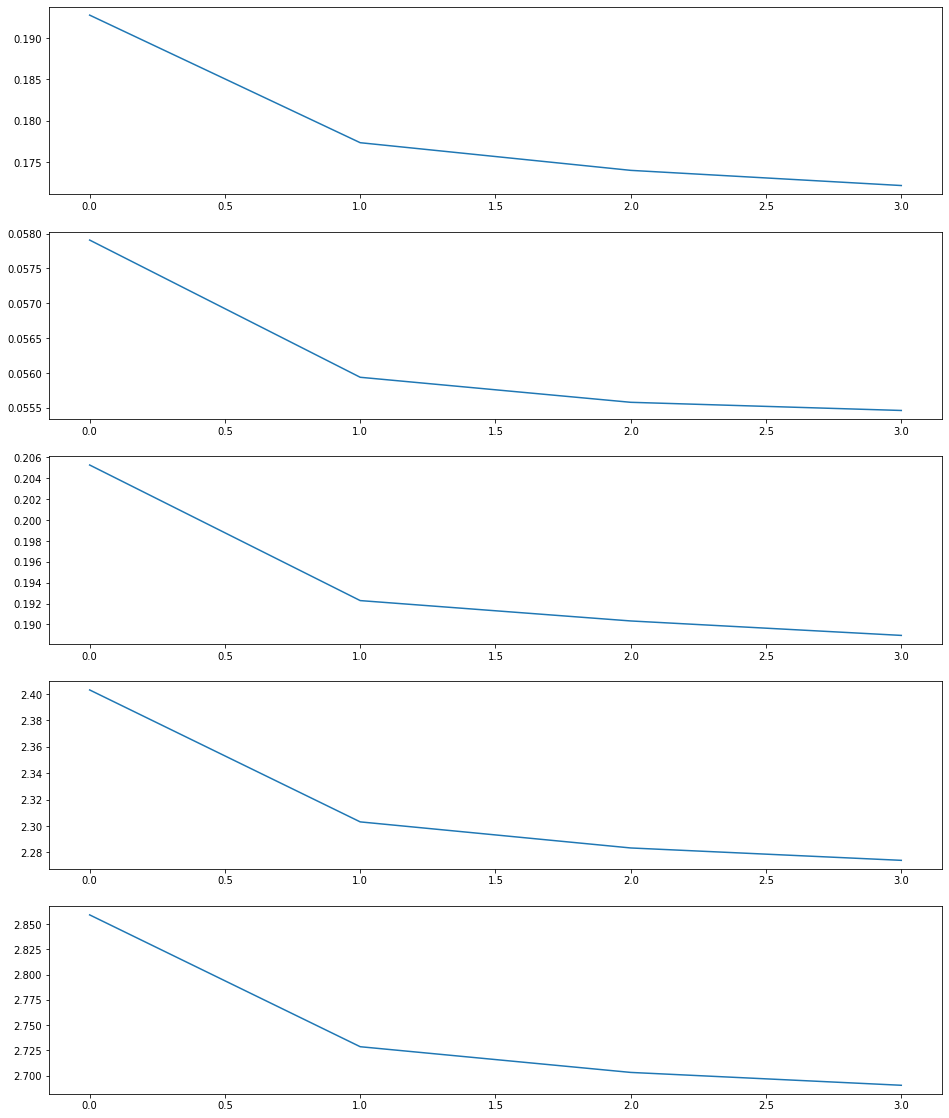

In [9]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1)

ax1.plot(train_epoch_loss_classifier)

ax2.plot(train_epoch_loss_box_reg)

ax3.plot(train_epoch_loss_objectness)

ax4.plot(train_epoch_loss_rpn_box_reg)

ax5.plot(train_epoch_loss_sum)